# Introduction
- 本教程参考系列教程及代码：[bentrevett / pytorch-seq2seq](https://github.com/bentrevett/pytorch-seq2seq)
- 论文原文：[Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215)

在本教程中，我们将要实现最常见的序列到序列 (sequence to sequence) 模型：`encoder-decoder model`.

**encoder**: 首先第二个 循环神经网络(`RNN`) 作为编码器，每时间步输入一个单词，将源句编码为单个上下文向量(`context vector`)，并将其视为整个句子的向量化抽象表示.

**decoder**: 第二个 `RNN` 作为解码器，将上下文向量解码为目标句子，每一个时间步输出一个单词.

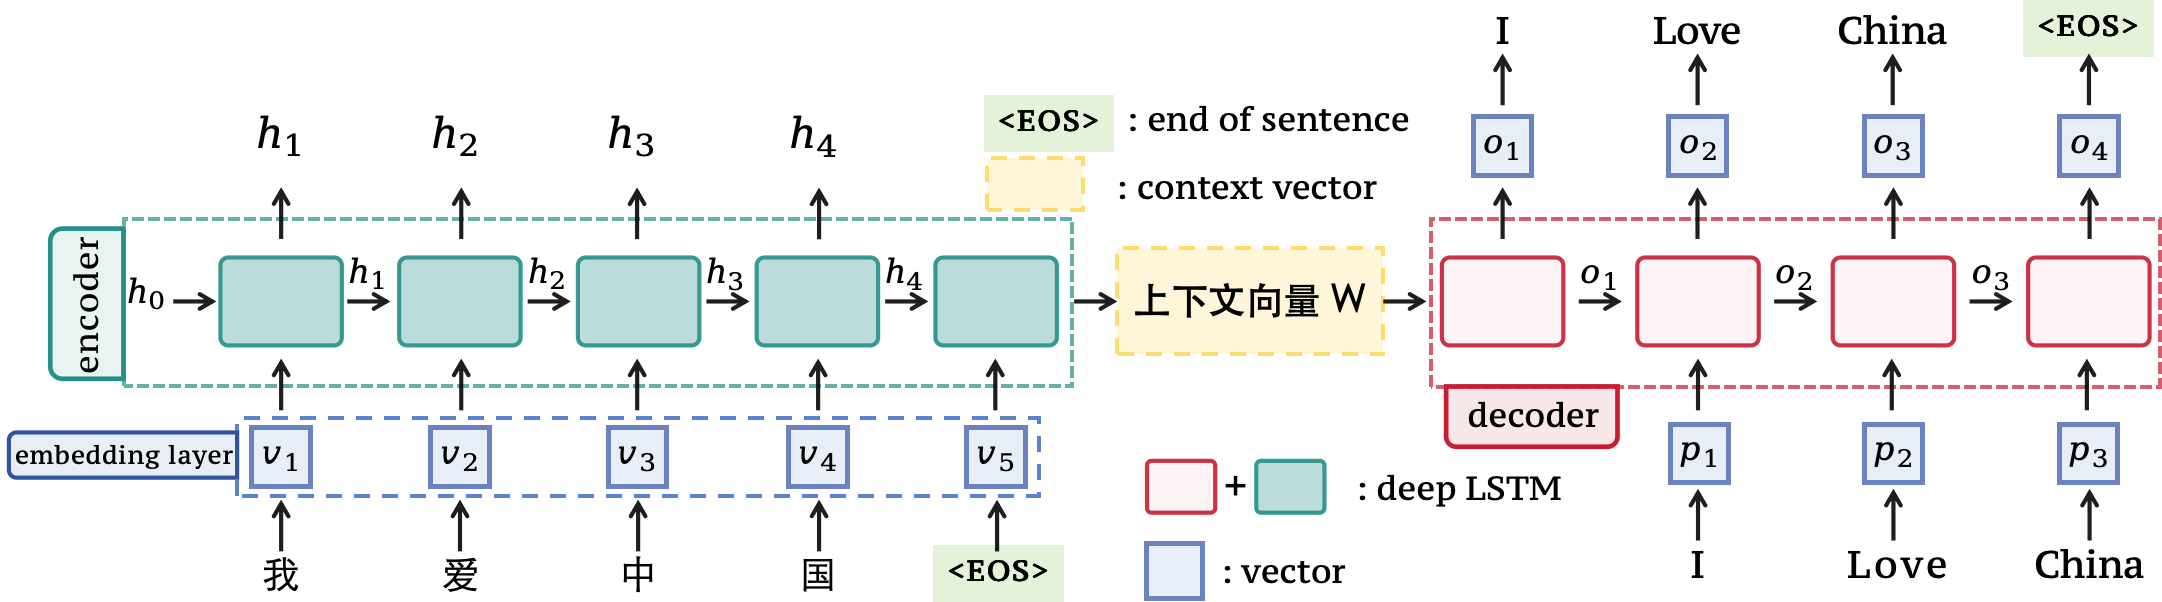
上图中就是经典的 `encoder-decoder model`.

在 **编码过程** 中，源句中的每一个单词都需要首先进行向量化编码，记为 $v_i$. 每一个 `RNN` 小组件都会接受两个输入：单词的向量化表示 $v_i$ 和上一步的输出向量(称为隐藏状态) $h_{i-1}$.

句子结尾时记录为 `<EOS>`(end of sentence). 接着编码过程结束，输出整个句子的向量化抽象表示，记为 $W$，称之为上下文向量(`context vector`)，其代表整个源句. 最后一个隐藏状态 $h_T$ 就作为 上下文向量 `context vector`， 同时也作为 decoder 的第一个输入 $o_0$.

在 **解码过程** 中，每个 `RNN` 小组件会输出一个向量 $o_i$，将其解码后就可以得到 目标单词；每个 `RNN` 小组件会接受两个输入：上一步的输出向量 $o_{i-1}$ 和 上一步输入单词再编码后的向量 $p_{i-1}$(也许 $o_{i-1}$ 和 $p_{i-1}$ 不一样). 

`注`：
- $h_0$ 为 decoder 的初始输入，常初始化为 全零向量 或 随机初始化
- 自然语言首先需要通过 **嵌入层**(`embedding layer`)将自然语言转化为向量，以输入模型
- `RNN` 也可以用 `LSTM` (Long Short-Term Memory) 或 `GRU` (Gated Recurrent Unit) 代替
- `encoder` 和 `decoder` 的 `embedding layer` 是不一样的，有各自不同的参数
- `输出向量 → 输出词语???`

# Codes

## Preparation
- torch, 本教程使用的 torch 版本为 2.2.0
- torch.nn as nn
- torch.optim as optim
- random
- numpy as np
- spacy  # 开源的自然语言处理(NLP)库
- datasets  # 是Hugging Face公司开发的一个Python库，提供了访问和处理大量自然语言处理(NLP)数据集的工具
- tqdm  # 用于显示进度条
- evaluate  # 简化模型评估过程，计算各种指标
- torchtext  # PyTorch官方用于自然语言处理(NLP)的工具包, 本教程使用的版本为 0.17.0, 不同的 torch 与 torchtext 版本适配可详见 [pytorch
text](https://github.com/pytorch/text/#installation)

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import spacy
import datasets
import tqdm
import evaluate
import torchtext

In [39]:
# 固定随机种子，以获得可重复确定性结果
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

## Dataset 
从 `HuggingFace dataset` 下载数据集并拆分为 `train dataset`, `validation dataset`, `test dataset`

In [40]:
dataset = datasets.load_dataset("bentrevett/multi30k")  # 共 30,000 条 英语 → 德语 句子，其中 29k 为 train，1k 为 test
dataset  # 查看 dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [41]:
# 为方便，将 dataset 拆分成 train, validation, test 三部分
train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

train_data[1]  # 查看 train dataset 的第二条数据

{'en': 'Several men in hard hats are operating a giant pulley system.',
 'de': 'Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.'}

## Tokenizers
token: 一个单词、符号、数字等等一个句子中可能出现的独立单位

使用 spaCy model 作为 Tokenizers，将一句话分词，例如 "Hi, I am Ray!" → ["Hi", "I", "am", "Ray", "!"]

针对不同的语言 spaCy model 有不同的模型，例如
- 德语："de_core_news_sm"
- 英语： "en_core_web_sm"
- 中文："zh_core_web_sm"

首次使用 spaCy 需要下载相应的模型，在终端中输入如下命令

`python -m spacy download en_core_web_sm`

`python -m spacy download de_core_news_sm`

### Preparation

In [42]:
# load 模型
en_nlp = spacy.load("en_core_web_sm")  # 英文分词器
de_nlp = spacy.load("de_core_news_sm")  # 德文分词器

`.tokenizer` 接受句子，返回对应的所有 token

`.text` 再将 token 转回 text

In [43]:
# 测试分词
string = "Hi, I am Ray!"
string_list = [token.text for token in en_nlp.tokenizer(string)]
print("string list:", string_list, "\n", "type of each element:", type(string_list[0]))

string list: ['Hi', ',', 'I', 'am', 'Ray', '!'] 
 type of each element: <class 'str'>


In [44]:
def tokenize_example(example, en_nlp, de_nlp, max_length, lower, sos_token, eos_token):
    """
    使用英文和德文的nlp模型进行分词，分别获取英文和德文的token列表
    返回新创建的 en_tokens, de_tokens 特征
    example: 语料库
    en_nlp, de_nlp: 英文和德文的nlp模型
    max_length: 最大 token 数, 一般为 1000
    lower: 是否需要转为小写
    sos_token, eos_token: 开始符与结束符
    """
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]  # 获取英文句子的前 max_length 个 tokens
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]  # 获取英德文句子的前 max_length 个 tokens
    if lower:  # 如果需要，将所有tokens转换为小写字母
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    # 在tokens的开头和结尾分别添加<sos>（开始符）和<eos>（结束符）
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

### Tokennize all sentences

In [45]:
max_length = 1_000  # 固定最大长度为 1000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp,            # 英文的 NLP 分词模型
    "de_nlp": de_nlp,            # 德文的 NLP 分词模型
    "max_length": max_length,    # 最大句子长度
    "lower": lower,              # 是否转为小写
    "sos_token": sos_token,      # 开始符
    "eos_token": eos_token,      # 结束符
}

train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)  # map 函数: 将指定函数应用于可迭代对象的每一个元素
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

In [46]:
# 测试分词效果
valid_data[0]

{'en': 'A group of men are loading cotton onto a truck',
 'de': 'Eine Gruppe von Männern lädt Baumwolle auf einen Lastwagen',
 'en_tokens': ['<sos>',
  'a',
  'group',
  'of',
  'men',
  'are',
  'loading',
  'cotton',
  'onto',
  'a',
  'truck',
  '<eos>'],
 'de_tokens': ['<sos>',
  'eine',
  'gruppe',
  'von',
  'männern',
  'lädt',
  'baumwolle',
  'auf',
  'einen',
  'lastwagen',
  '<eos>']}

## Vocabulary
下面将为源语言和目标语言构建词汇表，用于将数据集中的每个 token 与一个 index(整数)关联。当输入文本数据时，我们将字符串转换为 token list，再通过词汇表将标记转换为数字, 例如
`"I am Ray" → ["I", "am", "Ray"] → [1, 2, 3]`(第一步为 tokenize, 第二步为 关联 token 与 index)

- 使用 `torchtext` 的 `build_vocab_from_iterator` 函数从数据集中为两种语言 **分别** 创建词汇表. 为每个出现过的 token 分配一个数字(整数).
- 为避免 **信息泄漏(information leakage)**，词汇表 **仅基于训练集构建**.
- 我们还会为词汇表添加特殊标记，如`<unk>`、`<sos>`、`<eos>` 和 `<pad>`.
  - `<unk>`: unknown token, 该 token 在验证集和测试集中出现，但训练集中未出现，为一大类 tokens. `<unk>` 常对应 0.
  - `<sos>`: start of sentence, 句子开始
  - `<eos>`: end of sentence, 句子结束
  - `<pad>`: padding, 对需要填充位置补充的 token
- 由于 test set 和 valid set 中有可能出现 `<unk>`, 训练集中一个好的方式是也添加部分 `<unk>` , 使得模型能够学到处理 `<unk>` 的能力. 在这里我们将出现频次小于 `min_freq` 的 token 都换成 `<unk>`.
- 在模型中，一个 batch 要输入多个句子，但需要将它们填充到相同长度以进行批处理，填充通过添加 `<pad>` 标记实现.

In [47]:
min_freq = 2  # 最低词频阈值, 低于 min_freq 将被替换为 unk_token
unk_token = "<unk>"  # 用于表示词汇表中不存在的标记
pad_token = "<pad>"  # 用于将句子填充到相同长度以便批处理

# 定义所有特殊标记
special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

# 创建 vocabulary
en_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["en_tokens"],  # 英文分词数据, 一定要使用 train set 构建 vocabulary
    min_freq=min_freq,        # 最低词频阈值
    specials=special_tokens,  # 添加特殊标记（会自动放在词汇表前部）
)

de_vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["de_tokens"],  # 德文分词数据
    min_freq=min_freq,
    specials=special_tokens,
)

In [48]:
# 使用 .get_itos() 获取排序好的 tokens
print("top 15 tokens in English:", en_vocab.get_itos()[:15])  # 前 15 个 tokens, 特殊 token 在前
print("top 15 tokens in German:", de_vocab.get_itos()[:15])  # 前 15 个 tokens, 特殊 token 在前
print("===============================================================================================================================")
print("the 'boy' in English tokens list is located at:", en_vocab.get_stoi()["boy"], "the index of it is ", en_vocab["boy"])  # 返回某 token 出现在 English tokens list 中的位置
print("the 'boy(junge in German)' in German tokens list is located at:", de_vocab.get_stoi()["junge"], "the index of it is ", de_vocab["junge"])  # 返回某 token 出现在 German tokens list 中的位置
# 注意由于来自不同的语言，因此两个 token list 顺序还是不一样的，即使代表的意思都是一样的
print("===============================================================================================================================")
print("the length of Engilsh tokens list is", len(en_vocab))
print("the length of German tokens list is", len(de_vocab))

top 15 tokens in English: ['<unk>', '<pad>', '<sos>', '<eos>', 'a', '.', 'in', 'the', 'on', 'man', 'is', 'and', 'of', 'with', 'woman']
top 15 tokens in German: ['<unk>', '<pad>', '<sos>', '<eos>', '.', 'ein', 'einem', 'in', 'eine', ',', 'und', 'mit', 'auf', 'mann', 'einer']
the 'boy' in English tokens list is located at: 34 the index of it is  34
the 'boy(junge in German)' in German tokens list is located at: 26 the index of it is  26
the length of Engilsh tokens list is 5893
the length of German tokens list is 7853


In [49]:
# 尽管已经手动检查了特殊符号的位置在两种语言中是相通的，但是还是使用 assert 函数确保英语和德语词汇表中特殊符号的索引一致
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [50]:
# .set_default_index: 当查询不存在于词汇表的单词时，自动返回指定的默认索引
# 将超出 vocabulary 的词语的 index 统一设定为 unk_index(即 0)
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

# 测试
string = "Hi, I am Ray!"
string_list = [token.text for token in en_nlp.tokenizer(string)]

string_indexs = en_vocab.lookup_indices(string_list)
string_tokens = en_vocab.lookup_tokens(string_indexs)
print(" The string is: ", string, "\n", "The vector of this string is", string_indexs,  "\n", "The tokens of this string is", string_tokens)

 The string is:  Hi, I am Ray! 
 The vector of this string is [0, 15, 0, 2647, 0, 1180] 
 The tokens of this string is ['<unk>', ',', '<unk>', 'am', '<unk>', '!']


In [51]:
# 下面仿照函数 tokenize_example, 将数据集集中的句子再创建 index 特征, 即将 toekns → indexs
def numericalize_example(example, en_vocab, de_vocab):
    """
    将 token 列表数值化, toekns → indexs
    返回新创建的 en_ids, de_ids 特征
    example: 语料库
    en_vocab: 英文词汇表
    de_vocab: 德文词汇表
    """
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [52]:
fn_kwargs = {"en_vocab": en_vocab, "de_vocab": de_vocab}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

In [53]:
# 测试, train dataset 的第二条数据
print(train_data[1])
print(" train_data 中第二条数据的 index 编码(数值编码)为:", train_data[1]["en_ids"], "\n",
    "train_data 中第二条数据的 token 编码为:", en_vocab.lookup_tokens(train_data[1]["en_ids"]))

{'en': 'Several men in hard hats are operating a giant pulley system.', 'de': 'Mehrere Männer mit Schutzhelmen bedienen ein Antriebsradsystem.', 'en_tokens': ['<sos>', 'several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.', '<eos>'], 'de_tokens': ['<sos>', 'mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem', '.', '<eos>'], 'en_ids': [2, 113, 30, 6, 325, 279, 17, 1201, 4, 715, 4318, 2878, 5, 3], 'de_ids': [2, 76, 30, 11, 831, 2068, 5, 0, 4, 3]}
 train_data 中第二条数据的 index 编码(数值编码)为: [2, 113, 30, 6, 325, 279, 17, 1201, 4, 715, 4318, 2878, 5, 3] 
 train_data 中第二条数据的 token 编码为: ['<sos>', 'several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system', '.', '<eos>']


In [54]:
# 为方便后续输入 torch, 需要将 dataset 中的数值数据转化为张量 / tensor 形式(torch 形式)
data_type = "torch"  # tensor 形式
format_columns = ["en_ids", "de_ids"]

# with_format 方法将由列参数指示的特征转换为给定类型
train_data = train_data.with_format(
    type=data_type,          # 将数据字段转换为 PyTorch 张量
    columns=format_columns,  # 仅转换指定列
    output_all_columns=True  # 保留数据集所有原始列
)

valid_data = valid_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type,
    columns=format_columns,
    output_all_columns=True,
)

# 测试是否已变为 tensor 形式
if type(train_data[1]["en_ids"]) == torch.Tensor:
    print("已变为 tensor 形式")

已变为 tensor 形式


## Dataloader
本处的主要目的是填充和打包批次
DataLoader 的五大核心功能（以 PyTorch 为例）
| 功能                | 作用                          | 代码示例                      | 实际意义                           |
|---------------------|-------------------------------|-----------------------------|----------------------------------|
| **批处理**<br>(Batching) | 将数据打包成小批量<br>（如 32 条/批） | `batch_size=32`             | 利用 GPU 并行计算，加速训练         |
| **多进程加载**<br>(Multiprocessing) | 异步预加载数据              | `num_workers=4`             | 避免 GPU 等待数据准备             |
| **数据打乱**<br>(Shuffling) | 随机重排数据顺序           | `shuffle=True`              | 防止模型记忆样本顺序（过拟合）      |
| **自动填充**<br>(Padding) | 统一序列长度               | `collate_fn=pad_sequence`   | 处理变长输入（如 NLP 中的不同长度句子） |
| **采样策略**<br>(Sampling) | 控制数据选取方式          | `sampler=WeightedRandomSampler` | 处理类别不平衡问题               |


In [55]:
def get_collate_fn(pad_index):  # 将需要填充的位置都填充为 pad_index(这里为 1)
    def collate_fn(batch):      # 处理 batch 中的一批数据
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        # 填充对齐
        batch_en_ids = nn.utils.rnn.pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = nn.utils.rnn.pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }  # 重组批数据
        return batch

    return collate_fn

In [56]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):  # 默认不打乱
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,  # 默认不打乱
    )
    return data_loader

In [57]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## The Model
下面将通过三个部分构建模型：
- 编码器 encoder
- 解码器 decoder
- seq2seq model (将 encoder 与 decoder 组装)

有关 RNN 的介绍可以看视频 [【循环神经网络】5分钟搞懂RNN，3D动画深入浅出](https://www.bilibili.com/video/BV1z5411f7Bm/?spm_id_from=333.337.search-card.all.click&vd_source=fca2916b27f02d9580072fffc926831c)

有关 LSTM 的介绍可以看博客 [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

关于各种 PyTroch 的命令，详见官方文档 [torch.nn](https://pytorch.org/docs/stable/nn.html)

### Encoder
在原文中，使用了 4层的 LSTM, 但此处为快速运行程序, 只使用两层的 LSTM 以供展示.

将所有的 hidden states 记为 $\mathcal{H}=\{h_1, \cdots, h_T\}$.
当使用一个两层的 RNN 时, 
$$
h_i^1 = \text{encoderRNN}^1(e(x_i), h_{i-1}^1)
$$
$$
h_i^2 = \text{encoderRNN}^2(h_i^1, h_{i-1}^2)
$$
其中 $e(x_i)$ 为向量化编码层

若换为 两层的 LSTM, 则为
$$
(h_i^1, c_i^1) = \text{encoderLSTM}^1(e(x_i), h_{i-1}^1, c_{i-1}^1)
$$
$$
(h_i^2, c_i^2) = \text{encoderLSTM}^2(e(x_i), h_{i-1}^2, c_{i-1}^2)
$$


In [58]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, n_layers, dropout):
        """
        <类的构造函数>
        input_dim:     输入的词汇表大小
        embedding_dim: 词嵌入维度
        hidden_dim:    LSTM 中隐藏状态的维度
        n_layers:      LSTM 的层数
        dropout:       在 LSTM 层之间使用的 Dropout 概率，用来减少过拟合
        """
        super().__init__()  # 继承 PyTorch 模块的所有功能
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)  # 词嵌入, input_dim 嵌入为 embedding_dim
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        """
        <前向传播函数>
        src:  输入的源语言序列, 形状为 [src length, batch size], 即[源语言句子的长度, 批处理大小]
        输出(output):
        1. outputs = [src length, batch size, hidden dim * n directions] = [源语言句子的长度, 批处理大小, LSTM 的隐藏状态维度 * 方向数], LSTM 的输出
        2. hidden = [n layers * n directions, batch size, hidden dim], LSTM 的最后一个隐藏状态(即 LSTM 的每一层的输出)
        3. cell = [n layers * n directions, batch size, hidden dim], LSTM 的最后一个cell状态, 与 hidden 维度相同
        """
        # src = [src length, batch size]
        embedded = self.dropout(self.embedding(src))  # 每个词都被转换为一个嵌入向量, Dropout 被应用在嵌入层的输出上. embedded = [src length, batch size, embedding dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs are always from the top hidden layer
        return hidden, cell

### Decoder

In [59]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embedding_dim, hidden_dim, n_layers, dropout):
        """
        <类的构造函数>
        output_dim:     输出的词汇表大小, 即每个时间步的预测输出的维度
        embedding_dim: 词嵌入维度
        hidden_dim:    LSTM 中隐藏状态的维度
        n_layers:      LSTM 的层数
        dropout:       在 LSTM 层之间使用的 Dropout 概率，用来减少过拟合
        """
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, embedding_dim)  # 将每一个 LSTM 的输出 embedding 一下, 这样才能再输入回下一个 时间步的 LSTM
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=dropout)  # 可以看到这里的输入维度不是 output_dim, 而是 embedding_dim
        self.fc_out = nn.Linear(hidden_dim, output_dim)  # 全连接层, 将 LSTM 的输出转换为预测的输出(即输出词汇表)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        """
        <前向传播函数>
        input:  输入, 批量数据中的单个词索引, 形状为 [batch size]
        输出(output):
        1. output = [seq length, batch size, hidden dim * n directions] = [目标语言句子的长度(为1), 批处理大小, LSTM 的隐藏状态维度 * 方向数(一般为1)], LSTM 的输出
        2. hidden = [n layers * n directions, batch size, hidden dim], LSTM 的最后一个隐藏状态(即 LSTM 的每一层的输出)
        3. cell = [n layers * n directions, batch size, hidden dim], LSTM 的最后一个cell状态, 与 hidden 维度相同
        4. prediction = [batch size, output dim]
        """
        input = input.unsqueeze(0)  # 增加一个维度(表示时间), 让 input 维度变为 [1, batch size], 以符合 LSTM 的输入要求
        embedded = self.dropout(self.embedding(input))  # 每个词都被转换为一个嵌入向量, Dropout 被应用在嵌入层的输出上. embedded = [1, batch size, embedding dim]
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))  # 去掉多余的维度, 维度 prediction = [batch size, output dim]
        return prediction, hidden, cell

### Seq2Seq Model
Seq2Seq Model 需要将 encoder decoder 结合起来

在训练中, 需要使用到 `teacher forcing ratio`(教师强制比例). `teacher forcing` 的核心思想是: 在训练过程中, 将真实的目标(ground-truth)输出作为下一时间步的输入, 而不是让模型自己根据前一步的预测进行生成, 从而防止错误随着时间步的向前而不断积累. `teacher_forcing_ratio` 是一个概率值, 表示在每个时间步, 使用真实目标作为下一个时间步输入的概率.

在 decode 中, 我们已知目标句子应该有多长(trg_length), 因此可以循环进行 decode. 
1. 在一个循环中 $t$ , $(y_{t-1}, h_{t-1}, c_{t-1})\rightarrow$ decoder $\rightarrow (\hat{y}_{t+1}, h_{t}, c_{t})$
2. 将 prediction $\hat{y}_{t+1}$ 储存在 outputs(tensor) $\hat{Y}$ 中
3. 决定是否使用 `teacher forcing`: 使用 均匀随机数判定, 若随机数 < teacher_forcing_ratio 则使用 `teacher forcing`, 否则选择最大可能性的输出作为下一步输入(`.argmax(1)`)

注意由于所有的句子第一个元素 [0] 都是 `<SOS>`, 因此 target sentence 和 outputs 类似
- trg = [`<SOS>`, $y_1, y_2, y_3$, `<EOS>`]
- outputs = [0, $\hat{y}_1, \hat{y}_2, \hat{y}_3$, `<EOS>`]

在计算 loss 时, 需要将 第 [0] 位置的 `<SOS>` 切除

In [64]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        """
        <类的构造函数>
        encoder: 编码器
        decoder: 解码器
        device: 训练设备, GPU(若有) / CPU
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        assert (
            encoder.hidden_dim == decoder.hidden_dim  # 确保编码器和解码器的 隐藏维度(hidden_dim) 一致
        ), "Hidden dimensions of encoder and decoder must be equal!"
        assert (
            encoder.n_layers == decoder.n_layers      # 确保编码器和解码器的 层数(n_layers) 一致
        ), "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio):
        """
        <前向传播函数>
        src: 源语言句子(source sentence), src = [src length, batch size]
        trg: 目标语言句子(target sentence), trg = [trg length, batch size]
        teacher_forcing_ratio: 教师强制比例(teacher forcing ratio)
        """
        batch_size = trg.shape[1]                 # 批量大小
        trg_length = trg.shape[0]                 # 目标序列长度
        trg_vocab_size = self.decoder.output_dim  # 目标词汇表大小
        outputs = torch.zeros(trg_length, batch_size, trg_vocab_size).to(self.device)  # 初始化存储 decoder 输出的张量
        hidden, cell = self.encoder(src)  # encoder 的最后一个 hidden state 作为 decoder 的初始 hidden state. hidden 与 cell 的维度: [n layers * n directions, batch size, hidden dim]
        input = trg[0, :]  # input = [batch size]. 解码器的第一个输入是 <sos> 标记
        # 解码
        for t in range(1, trg_length):
            output, hidden, cell = self.decoder(input, hidden, cell)  # embedding token + previous hidden & cell states → output tensor(predictions) + new hidden & cell states
            # output = [batch size, output dim], hidden = [n layers, batch size, hidden dim], cell = [n layers, batch size, hidden dim]
            outputs[t] = output  # 将输出保存到结果张量中
            teacher_force = random.random() < teacher_forcing_ratio  # 决定是否使用 teacher forcing(均匀随机数判定)
            top1 = output.argmax(1)  # 选择预测的最大值作为下一个输入
            input = trg[t] if teacher_force else top1  # 使用真实目标词作为下一个输入（teacher forcing），否则使用预测词. input = [batch size]
        return outputs

## Train the model

### Define the model
- 输入 & 输出 维度都由相应语言的 vocabulary 定义
- encoder 与 decoder 的 embedding 维数 与 drop dout 率可以不同
- encoder 与 decoder 的 LSTM 层数 与 hidden/cell state 的维数 **必须相同**
- 训练设备使用 `torch.cuda.is_available()` 命令, 若存在 GPU 则返回 `True`

In [68]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
hidden_dim = 512
n_layers = 2
encoder_dropout = 0.5
decoder_dropout = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    hidden_dim,
    n_layers,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    hidden_dim,
    n_layers,
    decoder_dropout,
)

model = Seq2Seq(encoder, decoder, device).to(device)
print("Our Sequence to sequence is:\n", model)

Our Sequence to sequence is:
 Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)


### Weight Initialization
与原文中一样, 使用 [-0.08, 0.08] 的均匀分布初始化参数. 先定义一个初始化函数 `init_weights`, 再使用 `model.apply` 初始化 模型

再定义参数量计算函数, 以计算可训练参数量(需要梯度的参数).
- `p.numel()`返回张量 p 中元素的总数
- `model.parameters()` 返回模型中的所有参数(包括权重和偏置)
- `if p.requires_grad` 确保是可训练参数

In [73]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)


model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [74]:
# 计算参数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"模型共 {count_parameters(model):,} 可训练参数")

模型共 13,898,501 可训练参数


### Optimizer, Loss Function
定义优化器(一般为 Adam) 与 损失函数(一般为交叉熵)

In [27]:
optimizer = optim.Adam(model.parameters())

In [28]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

### Loop

#### Training Loop
在每个 iteration 中
1. 从批次中获取源句子和目标句子，$X$ 和 $Y$
2. 将上一批计算出的梯度归零
3. 将源句子和目标句子输入模型中以获取输出 $\hat{Y}$
4. 由于损失函数仅适用于具有 1d 目标的 2d 输入，因此我们需要使用 `.view(-1, output_dim)` 展平每个输入
5. 使用 `loss.backward()` 计算梯度
6. 使用 `torch.nn.utils.clip_grad_norm_(model.parameters(), clip)` 剪切梯度以防止它们爆炸（RNN 中的常见问题）
7. 通过执行优化器步骤更新模型的参数
8. 将损失值加到运行总数

最后，我们返回所有批次的平均损失。

In [85]:
def train_fn(model, data_loader, optimizer, criterion, clip, teacher_forcing_ratio, device):
    model.train()   # 将模型设置为 训练模式
    epoch_loss = 0  # 初始化 epoch 总损失
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"].to(device)  # token 在 德文 vocabulary 中的编码, src = [src length, batch size]
        trg = batch["en_ids"].to(device)  # token 在 英文 vocabulary 中的编码, trg = [trg length, batch size]
        optimizer.zero_grad()             # 清空优化器中的梯度缓存
        output = model(src, trg, teacher_forcing_ratio)  # output = [trg length, batch size, trg vocabulary size]
        output_dim = output.shape[-1]             # output_dim = trg vocabulary size
        output = output[1:].view(-1, output_dim)  # 在 batch 中切除每一个 output sentence 的第一个 <SOS>, output = [(trg length - 1) * batch size, trg vocab size](这里直接.view(-1)也可以, 为了双重验证是否输出维度为 output_dim)
        trg = trg[1:].view(-1)                    # 在 batch 中切除每一个 target sentence 的第一个 <SOS>, trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg)             # 这里的 loss 是一个 batch 的 loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)  # 防止梯度爆炸
        optimizer.step()                  # 使用优化器更新模型参数
        epoch_loss += loss.item()         # 将损失从张量转换为 Python 标量, 并累加
    return epoch_loss / len(data_loader)  # 得到平均每个批次的损失

In [86]:
# 测试 .view(-1) 的作用
tensor = [[1, 2, 3], 
          [4, 5, 6]]
tensor = torch.tensor(tensor)
flattened_tensor = tensor.view(-1, 6)
flattened_tensor

tensor([[1, 2, 3, 4, 5, 6]])

#### Evaluation Loop
注意 相较于 train loop, 此处不需要 `loss.backward()` 和 `optimizer.step()`
1. `model.eval()` 将模型设置为 评估模式, 禁用 dropout, batch normalization 等
2. `with torch.no_grad()` 不计算梯度, 节省内存和加速计算(因为只需要计算 loss, 无需反向传播)
3. 需要关闭 `teacher forcing`, 让模型每次预测下一个词时都使用模型自己的预测而不是目标的真实值

In [87]:
def evaluate_fn(model, data_loader, criterion, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            src = batch["de_ids"].to(device)  # token 在 德文 vocabulary 中的编码, src = [src length, batch size]
            trg = batch["en_ids"].to(device)  # token 在 英文 vocabulary 中的编码, trg = [trg length, batch size]
            output = model(src, trg, 0)       # 关闭 teacher forcing, output = [trg length, batch size, trg vocab size]
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            epoch_loss += loss.item()
    return epoch_loss / len(data_loader)

## Model Train

In [60]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

print("Training on", device)

for epoch in tqdm.tqdm(range(n_epochs)):
    train_loss = train_fn(
        model,
        train_data_loader,
        optimizer,
        criterion,
        clip,
        teacher_forcing_ratio,
        device,
    )
    valid_loss = evaluate_fn(
        model,
        valid_data_loader,
        criterion,
        device,
    )
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "tut1-model.pt")
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

Training on cpu


  0%|                                                    | 0/10 [00:05<?, ?it/s]


KeyboardInterrupt: 

## Evaluation

In [88]:
model.load_state_dict(torch.load("tut1-model.pt"))

test_loss = evaluate_fn(model, test_data_loader, criterion, device)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 3.776 | Test PPL:  43.624 |


In [89]:
def translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
    max_output_length=25,
):
    """
    sentence：待翻译的输入句子，可以是字符串（德文）或者是已经分词的列表（token）
    model：已训练好的 Seq2Seq 模型
    en_nlp 和 de_nlp：英文和德文的自然语言处理模型（通常用于分词）
    en_vocab 和 de_vocab：英文和德文的词汇表，用于词索引与词向量之间的映射
    lower：是否将输入的词转换为小写
    sos_token 和 eos_token：开始符 <sos> 和结束符 <eos>
    device：设备，通常是 GPU 或 CPU
    max_output_length：生成的最大输出长度，默认为 25
    """
    model.eval()
    with torch.no_grad():
        if isinstance(sentence, str):  # 如果输入已经是分词后的句子（如一个词的列表）, 则直接使用它
            tokens = [token.text for token in de_nlp.tokenizer(sentence)]
        else:
            tokens = [token for token in sentence]
        if lower:  # 是否小写
            tokens = [token.lower() for token in tokens]
        tokens = [sos_token] + tokens + [eos_token]
        ids = de_vocab.lookup_indices(tokens)
        tensor = torch.LongTensor(ids).unsqueeze(-1).to(device)
        hidden, cell = model.encoder(tensor)
        inputs = en_vocab.lookup_indices([sos_token])
        for _ in range(max_output_length):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden, cell = model.decoder(inputs_tensor, hidden, cell)
            predicted_token = output.argmax(-1).item()
            inputs.append(predicted_token)
            if predicted_token == en_vocab[eos_token]:
                break
        tokens = en_vocab.lookup_tokens(inputs)
    return tokens

In [117]:
# 测试 1
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

print("The German is: ", sentence)
print("The expected translation is: ", expected_translation)

translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print("The model output is: ", " ".join(translation[1:-1]))

The German is:  Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
The expected translation is:  A man in an orange hat starring at something.
The model output is:  a man in a blue hat is cutting something .


In [112]:
# 测试 2
sentence = "Ein Mann sitzt auf einer Bank."

translation = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
    device,
)

print("The German is: ", sentence)
print("The model output is: ", " ".join(translation[1:-1]))

The German is:  Ein Mann sitzt auf einer Bank.
The model output is:  a man sitting on a bench .


In [119]:
# 测试 3, 测试所有 test data 中的数据
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token,
        device,
    )
    for example in tqdm.tqdm(test_data)
]

bleu = evaluate.load("bleu")

predictions = [" ".join(translation[1:-1]) for translation in translations]

references = [[example["en"]] for example in test_data]

100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.24it/s]


In [158]:
predictions[0:2], references[0:2]

(['a man in a blue hat is cutting something .',
  'a large dog runs through the grass with a large . .'],
 [['A man in an orange hat starring at something.'],
  ['A Boston Terrier is running on lush green grass in front of a white fence.']])

### Calculate the BLEU

In [123]:
def get_tokenizer_fn(nlp, lower):
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens

    return tokenizer_fn

tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

In [155]:
tokenizer_fn(predictions[0]), tokenizer_fn(references[0][0])  # 注意 references 是 list 嵌套 list

(['a', 'man', 'in', 'a', 'blue', 'hat', 'is', 'cutting', 'something', '.'],
 ['a', 'man', 'in', 'an', 'orange', 'hat', 'starring', 'at', 'something', '.'])

In [160]:
results = bleu.compute(
    predictions=predictions, references=references, tokenizer=tokenizer_fn
)

results

{'bleu': 0.12231089762379209,
 'precisions': [0.488120050020842,
  0.18244656662119146,
  0.08524262131065533,
  0.04202334630350195],
 'brevity_penalty': 0.9151930444291762,
 'length_ratio': 0.9185939653852044,
 'translation_length': 11995,
 'reference_length': 13058}